# Método de Gauss_Newton aplicado à função geofísica

Algoritmo de Gauss_Newton aplicado a um problema geofísico para estimar o raio e o topo de um prisma de base poligonal próximo de um cilindro.

# Importando pacotes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
import cPickle as pickle
from visual import histeq
from fatiando import utils
from fatiando.mesher import PolygonalPrism
from IPython.display import Image as img
from fatiando.gravmag import polyprism
from copy import deepcopy
from fatiando.gridder import regular

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


# Função geofísica

In [2]:
def geofisica(xp, yp, zp, p, M, dz, props, dobs, inc, dec):
    '''
    This function calculates the data for polygonal
    prisms of the Fatiando a Terra with the two given parameters.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    p: 1D array - parameter vector
    M: int - number of vertices
    L: int - number of prisms
    z0: float - top of the model
    dz: float - thickness of each prism
    props: dictionary - physical property
    dobs: 1D array - observed data
    inc: float - inclination
    dec: declination

    output

    prism: list - list of objects of the class fatiando.mesher.PolygonalPrism
    d: 1D array - data vector
    res: 1D array - residual data
    phi: float - misfit function value
    '''
    
    r = np.zeros(M) + p[0] # radial distance for each vertice

    # Cartesian coordinates of the origin of each prism
    x0 = 0. 
    y0 = 0.

    l = [r, x0, y0, p[1], p[1] + dz, props]   # list of parameters of the prisms
    
    ang = 2*np.pi/M # angle between two vertices
    
    prism = []
    verts=[]
    for i in range(M):
        verts.append([r[i]*np.cos(i*ang) + l[1], r[i]*np.sin(i*ang) + l[2]])
    prism.append(PolygonalPrism(verts, l[3], l[4], l[5]))
    
    d = polyprism.tf(xp, yp, zp, prism, inc, dec)
    res = dobs - d
    phi = np.sum(res*res)
    
    return prism, d, res, phi

# Modelagem direta

In [3]:
M = 10 # number of vertices per prism
L = 1 # number of prisms
P = L*(M+2) # number of parameters

z0_true = 100.    # depth of the top the shallowest prism
dz = 500.    # thickness of each prism

inc = -60.  # inclination
dec = 50.   # declination
intensity = 0.035 # intensity

props={'magnetization': utils.ang2vec(intensity, inc, dec)} # physical property: magnetization

r_true = 500.

r = np.zeros(M) + r_true # radial distance for each vertice

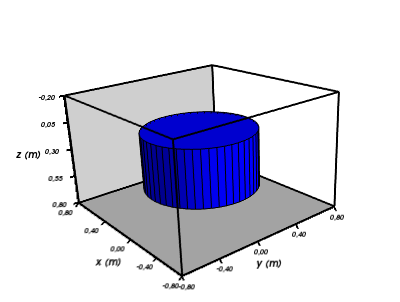

In [4]:
img(filename='bolacha.png')

# Pontos de observação

In [5]:
area = [-2000, 2000, -2000, 2000] #x minimum, x maximum, y minimum and y maximum
shape = (50,50) #number of data along the y and x directions
N = shape[0]*shape[1] #total number of data

#coordinates x and y of the data
xp, yp = regular(area, shape)

zp = np.zeros(N) - 100.

# Dados observados

In [6]:
p_true = np.array([r_true, z0_true])
prism_true, data, res_, phi_true = geofisica(xp, yp, zp, p_true, M, dz, props, np.zeros(xp.size), inc, dec)
amp_noise = 0.01*np.max(data)
data_noise = data + np.random.normal(loc=0., scale=amp_noise, size=shape[0]*shape[1]) # noise corrupted data

# Plot função desajuste

In [7]:
shape2 = (15,15)
r_plot = np.linspace(10., 1000., shape2[0])
z0_plot = np.linspace(-100., 500., shape2[1])
r_plot,z0_plot = np.meshgrid(r_plot, z0_plot)
r_plot = r_plot.ravel()
z0_plot = z0_plot.ravel()
phi_plot = np.zeros_like(r_plot)

for i, (r, z) in enumerate(zip(r_plot,z0_plot)):
    p = np.array([r, z])
    prism_pred, d_pred, res, phi_plot[i] = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)

r_plot = r_plot.reshape(shape2)
z0_plot = z0_plot.reshape(shape2)
phi_plot = phi_plot.reshape(shape2)

# equalizando as cores
phi_eq = histeq(phi_plot)
phi_eq = np.reshape(phi_eq,shape2)
phi_eq = phi_eq

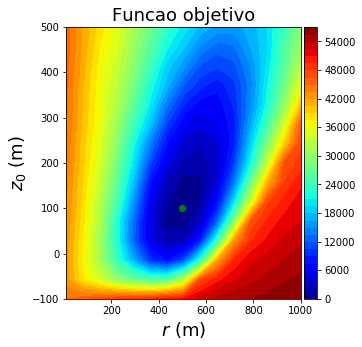

In [8]:
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'og')
plt.title('Funcao objetivo', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 50, cmap='jet')
plt.xlabel('$r$ (m)', fontsize=18)
plt.ylabel('$z_0$ (m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

# Funções

In [9]:
def derivative_tf_z0(xp, yp, zp, prism, M, deltaz, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of one fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    delta: float - increment in x coordinate in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - deltaa
    prism_plus[0].z1 += deltaz
    prism_minus[0].z1 -= deltaz

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltaz)

    return df

def derivative_tf_radiall(xp, yp, zp, prism, M, deltar, inc, dec):
    '''
    This function calculates the derivative for total field anomaly
    from a model of polygonal prisms using finite difference.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of a fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in radial distance in meters
    inc: float - inclination
    dec: declination

    output

    df: 1D array - derivative
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'
    
    ang = 2.*np.pi/M # angle between two vertices
    
    prism_plus = deepcopy([prism])  # m.x + delta
    prism_minus = deepcopy([prism])  # m.x - delta

    for i in range(M):
        deltax = deltar*np.cos(i*ang)
        deltay = deltar*np.sin(i*ang)
        prism_plus[0].x[i] += deltax
        prism_plus[0].y[i] += deltay
        prism_minus[0].x[i] -= deltax
        prism_minus[0].y[i] -= deltay

    df = polyprism.tf(xp, yp, zp, prism_plus, inc, dec)
    df -= polyprism.tf(xp, yp, zp, prism_minus, inc, dec)
    df /= (2.*deltar)

    return df

# calculando jacobiana de phi
def jacobi_geo(xp, yp, zp, prism, M, deltar, deltaz, inc, dec):
    '''
    Returns the sensitivity matrix for polygonal prisms using finite
    differences.

    input

    xp: array - x observation points
    yp: array - y observation points
    zp: array - z observation points
    prism: list - list of fatiando.mesher.PolygonalPrism
    M: int - number of vertices per prism
    deltar: float - increment in meters for radial distance
    deltaz: float - increment in meters for depth
    inc: float - inclination of the local-geomagnetic field
    dec: declination of the local-geomagnetic field

    output

    G: 2D array - sensitivity matrix
    '''
    assert xp.size == yp.size == zp.size, 'The number of points in x, y and z must be equal'

    G = np.zeros((xp.size, 2))

    G[:, 0] = derivative_tf_radiall(xp, yp, zp, prism[0], M, deltar, inc, dec)
    G[:, 1] = derivative_tf_z0(xp, yp, zp, prism[0], M, deltaz, inc, dec)

    return G

# Funções de regularização

In [10]:
def regularization(p0, mi0, mi1, mit):
    '''
    Returns the value, gradient and Hessian of the constraint function.
    
    input
    
    p0: 1D array - parameters vector
    mi0: float - zero order Tikhonov's regularization parameter
    mi1: float - one order smoothness regularization parameter
    mit: float - total variation regularization parameter
    
    output
    
    phi: float - value of constraint function
    grad: 1D array - gradient of constraint funtion
    H: 2D array - Hessian of constraint function
    '''
    H = mi0*np.identity(p0.size)
    grad = mi0*p0
    phi = np.dot(p0, grad)
    
    RTR = np.array([[1.,-1.], [-1.,1.]])
    H += mi1*RTR
    grad += mi1*np.dot(RTR, p0)
    phi += np.dot(p0, grad)
    
    return phi, grad, H

# Modelo interpretativo

In [11]:
# chute inicial
p01 = 990.
p02 = 10.

# incremento para as derivadas
deltar = 0.01*p01
deltaz = 0.01*p02

r = np.zeros(M) + p01 # radial distance for each vertice

# Cartesian coordinates of the origin of each prism
x0 = 0. 
y0 = 0.

# vetor do chute inicial
p0 = np.array([p01,p02])

#critétio de parada
epsilon = 0.00001

# parâmetros de regularização
mi0 = 0.00000
mi1 = 0.
mit = 0.

# calculando os prismas iniciais, o dado predito, o valor da função e do resíduo em p0
prism0, d0, res0, phi0 = geofisica(xp, yp, zp, p0, M, dz, props, data_noise, inc, dec)

# listas para armazenar as estimativas
p1_list = [p01]
p2_list = [p02]
phi_list = [phi0]

# iterações do algoritmo
itmax = 30

# Parâmetros para o plot das funções de regularização

In [12]:
phi_reg = np.zeros(shape2).ravel()
p_reg = np.zeros(2)
for i, (ri, zi) in enumerate(zip(r_plot.ravel(), z0_plot.ravel())):
    p_reg[0] = ri
    p_reg[1] = zi
    phi_reg[i], grad_reg, H_reg = regularization(p_reg, mi0, mi1,  mit)
    
phi_reg_plot = histeq(phi_reg)

In [13]:
phi_reg_plot = histeq(phi_reg)
phi_reg_plot = phi_reg.reshape(shape2)

# Algoritmo Gauss-Newton

In [14]:
for it in range(itmax):
    # calculando os elementos da regularização
    phi_reg, grad_reg, H_reg = regularization(p0, mi0, mi1, mit)
    # calculando a Jacobiana e o gradiente
    G = jacobi_geo(xp, yp, zp, prism0, M, deltar, deltaz, inc, dec)
    H = 2.*np.dot(G.T, G) + H_reg
    grad = -2.*np.dot(G.T, res0) + grad_reg
    
    # calculando p e atualizando para a próxima iteração
    p = p0 + np.linalg.solve(H, -grad)
    #print p, p0
    prism, d, res, phi = geofisica(xp, yp, zp, p, M, dz, props, data_noise, inc, dec)
    phi += phi_reg
    
    # printa os valores
    print 'itreação: %3d   r: %.2f   z: %.2f   misfit: %.2e' % (it, p0[0], p0[1], phi0)
    
    # armazenando os resultados em listas para o plot
    phi_list.append(phi)
    p1_list.append(p[0])
    p2_list.append(p[1])
    
    if (abs(phi-phi0)/phi0 <= epsilon):
        break
    else:
        # atualizando parâmetros
        p0 = p.copy()
        d0 = d.copy()
        res0 = res.copy()
        phi0 = phi
        prism0 = prism

itreação:   0   r: 990.00   z: 10.00   misfit: 2.00e+04
itreação:   1   r: 925.50   z: 189.44   misfit: 5.93e+03
itreação:   2   r: 712.71   z: 296.56   misfit: 1.24e+03
itreação:   3   r: 392.60   z: 150.57   misfit: 8.51e+02
itreação:   4   r: 543.29   z: 139.33   misfit: 1.05e+02
itreação:   5   r: 487.92   z: 104.56   misfit: 3.24e+01
itreação:   6   r: 499.78   z: 100.88   misfit: 2.07e+01
itreação:   7   r: 499.81   z: 100.13   misfit: 2.07e+01
itreação:   8   r: 499.92   z: 100.05   misfit: 2.07e+01


# Plots de resultados

In [15]:
res_norm = (res - np.mean(res))/np.std(res)
res_plot = res.reshape(shape)
dpred = data.reshape(shape)
dobs = data_noise.reshape(shape)

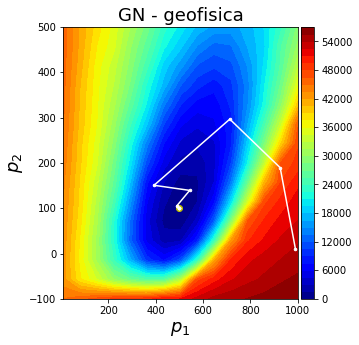

In [16]:
#plot
plt.figure(figsize=(5,5))
plt.plot(r_true, z0_true, 'oy')
plt.plot(p1_list, p2_list, '.w-', markersize=5)
plt.title('GN - geofisica', fontsize=18)
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet')
plt.xlabel('$p_1$', fontsize=18)
plt.ylabel('$p_2$', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1)
plt.show()

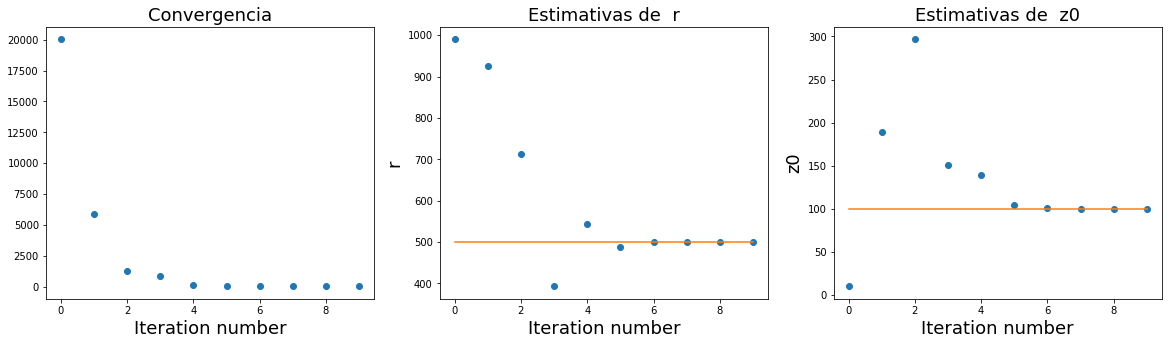

In [17]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Convergencia', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.plot(phi_list, 'o')

plt.subplot(1, 3, 2)
plt.title('Estimativas de  r', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.ylabel('r', fontsize = 18)
plt.plot(p1_list, 'o')
plt.plot(np.zeros(len(p1_list)) + r_true, '-')

plt.subplot(1, 3, 3)
plt.title('Estimativas de  z0', fontsize = 18)
plt.xlabel('Iteration number', fontsize = 18)
plt.ylabel('z0', fontsize = 18)
plt.plot(p2_list, 'o')
plt.plot(np.zeros(len(p1_list)) + z0_true, '-')
plt.show()

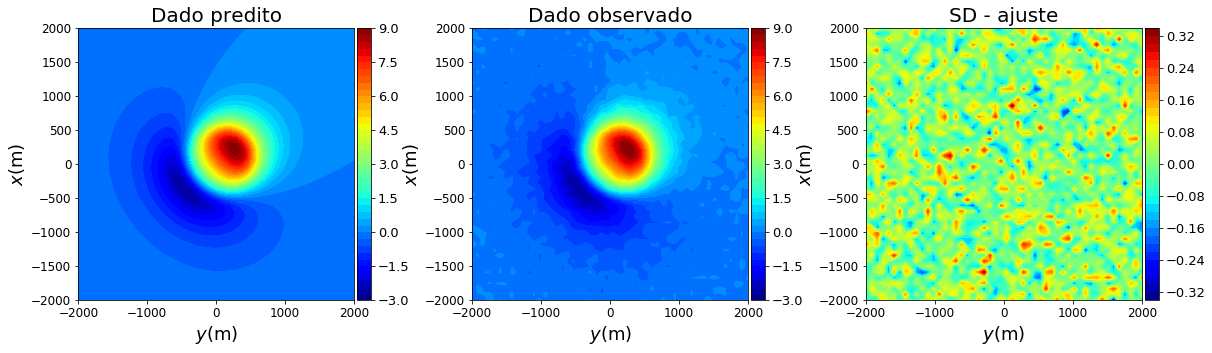

In [18]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Dado predito', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dpred, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 2)
plt.title('Dado observado', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), dobs, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)

plt.subplot(1, 3, 3)
plt.title('SD - ajuste', fontsize=20)
plt.contourf(yp.reshape(shape), xp.reshape(shape), res_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$y$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
clb.ax.tick_params(labelsize=13)
plt.show()

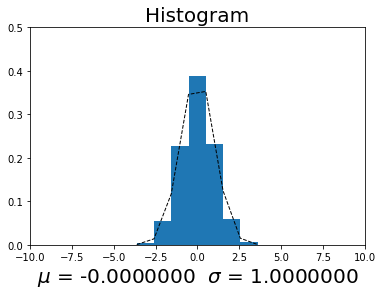

In [19]:
plt.plot(figsize=(30,25))
plt.title('Histogram', fontsize = 20)
plt.xlabel('$\mu$ = %.7f  $\sigma$ = %.7f' % (np.mean(res_norm), np.std(res_norm)), fontsize=20)
nbins = int((np.max(res_norm) - np.min(res_norm)))
n, bins, patches = plt.hist(res_norm,bins=nbins, normed=True)
gauss = normpdf(bins, np.mean(res_norm), np.std(res_norm))
plt.plot(bins, gauss, 'k--', linewidth=1.)
plt.ylim(0.,0.5)
plt.xlim(-10., 10.)
plt.show()

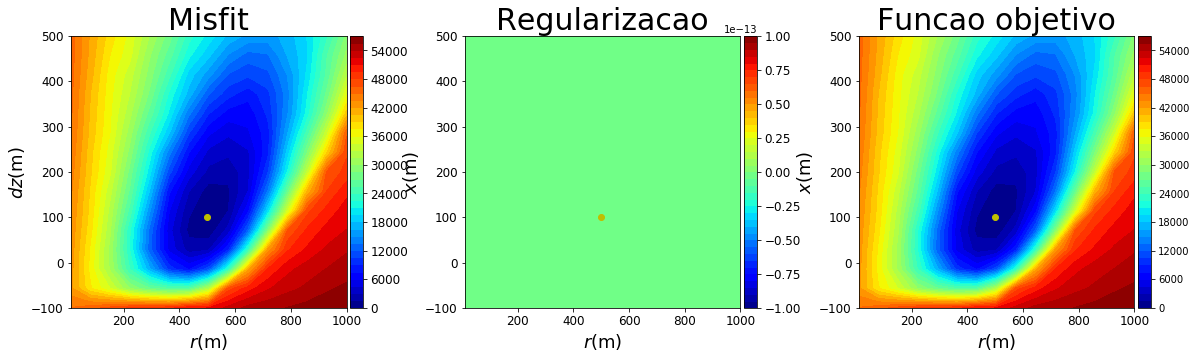

In [20]:
# plot
plt.figure(figsize=(20,5))
plt.subplot(1, 3, 1)
plt.title('Misfit', fontsize=30)
plt.plot(500., 100., 'oy')
plt.contourf(r_plot, z0_plot, phi_eq, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$r$(m)', fontsize=18)
plt.ylabel('$dz$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).ax.tick_params(labelsize=12)

plt.subplot(1, 3, 2)
plt.title('Regularizacao', fontsize=30)
plt.plot(500., 100., 'oy')
plt.contourf(r_plot, z0_plot, phi_reg_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$r$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
plt.colorbar(pad=0.01, aspect=20, shrink=1).ax.tick_params(labelsize=12)

plt.subplot(1, 3, 3)
plt.title('Funcao objetivo', fontsize=30)
plt.plot(500., 100., 'oy')
plt.contourf(r_plot, z0_plot, phi_eq+phi_reg_plot, 40, cmap='jet').ax.tick_params(labelsize=12)
plt.xlabel('$r$(m)', fontsize=18)
plt.ylabel('$x$(m)', fontsize=18)
clb = plt.colorbar(pad=0.01, aspect=20, shrink=1)
#clb.ax.tick_params(labelsize=18)
plt.show()